In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import operator
import warnings
warnings.filterwarnings('ignore')
import os
from queue import PriorityQueue
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

#from sacrebleu import raw_corpus_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Define constants here
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 32
TEST_BATCH_SIZE = 5
MAX_LENGTH = 80
words_to_load = 50000
emb_size = 300
wiki_size = 300
CUDA = True


In [4]:
datadir = os.getcwd() + '/'
datadir


'/home/ht1162/anaconda3/'

### Load pretrained word embeddings:
Reference: https://fasttext.cc/docs/en/pretrained-vectors.html

@article{bojanowski2017enriching,
  title={Enriching Word Vectors with Subword Information},
  author={Bojanowski, Piotr and Grave, Edouard and Joulin, Armand and Mikolov, Tomas},
  journal={Transactions of the Association for Computational Linguistics},
  volume={5},
  year={2017},
  issn={2307-387X},
  pages={135--146}
}


In [5]:
#Reference Lab4 HW2
# datadir = os.getcwd()
words_to_load = 50000
with open(datadir + 'wiki-news-300d-1M.vec') as f:
    loaded_en_embeddings = np.zeros(((words_to_load+4), wiki_size))
    en_word2id = {}
    en_id2words = {}
    
    en_id2words[PAD_TOKEN] = '<PAD>'
    en_id2words[SOS_TOKEN] = '<SOS>'
    en_id2words[EOS_TOKEN] = '<EOS>'
    en_id2words[UNK_TOKEN] = '<UNK>'
    
    en_word2id['<PAD>'] = PAD_TOKEN
    en_word2id['<SOS>'] = SOS_TOKEN
    en_word2id['<EOS>'] = EOS_TOKEN
    en_word2id['<UNK>'] = UNK_TOKEN
    
    en_ordered_words= []
    en_ordered_words.append('<PAD>')
    en_ordered_words.append('<SOS>')
    en_ordered_words.append('<EOS>')
    en_ordered_words.append('<UNK>')
    
    for i, line in enumerate(f):
        if i >= words_to_load:
            break
        if i ==0:#Ignore the first line
            continue;
        s = line.split()
        #print(len(s))
        loaded_en_embeddings[i+4,:] = np.asarray(s[1:])
        en_word2id[s[0]] = i+4 #for extra pad and unk eos and unk
        en_id2words[i+4] = s[0]
        en_ordered_words.append(s[0])

In [6]:
#Reference Lab4 HW2
#Over 200000 loaded words, 58 has wrong dimensions
#Too slow, swtiched to 50000
words_to_load = 50000
# datadir = os.getcwd()
with open(datadir + 'cc.zh.300.vec') as f:
    loaded_zh_embeddings = np.zeros(((words_to_load+4),wiki_size))
    zh_word2id = {}
    zh_id2words = {}
    
    zh_id2words[PAD_TOKEN] = '<PAD>'
    zh_id2words[SOS_TOKEN] = '<SOS>'
    zh_id2words[EOS_TOKEN] = '<EOS>'
    zh_id2words[UNK_TOKEN] = '<UNK>'
    
    zh_word2id['<PAD>'] = PAD_TOKEN
    zh_word2id['<SOS>'] = SOS_TOKEN
    zh_word2id['<EOS>'] = EOS_TOKEN
    zh_word2id['<UNK>'] = UNK_TOKEN
    
    zh_ordered_words= []
    zh_ordered_words.append('<PAD>')
    zh_ordered_words.append('<SOS>')
    zh_ordered_words.append('<EOS>')
    zh_ordered_words.append('<UNK>')
    wrong_dim = 0;
    for i, line in enumerate(f):
        #print(line)
        if i >= words_to_load:
            break;
        if i == 0: #Ignore the first line
            continue;
        s = line.split()
        if len(s) != 301:
            wrong_dim += 1#Skip the wrong dimension one
            continue;
        loaded_zh_embeddings[i+4,:] = np.asarray(s[1:])
        zh_word2id[s[0]] = i+4 #for extra pad and unk 
        zh_id2words[i+4] = s[0]
        zh_ordered_words.append(s[0])
    print('In total {} has wrong dimension, hence skipped'.format(wrong_dim))

In total 0 has wrong dimension, hence skipped


In [7]:
import pickle as pkl
pkl.dump(loaded_zh_embeddings, open(datadir+'zh_embeddings.p', 'wb'))
pkl.dump(loaded_en_embeddings, open(datadir+'en_embeddings.p', 'wb'))
#pkl.dump(loaded_vi_embeddings, open(datadir+'vi_embeddings.p', 'wb'))

In [8]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 3

class Lang:
    def __init__(self, name, emb_word2id, emb_id2word, emb_ordered_words):
        self.name = name
        self.word2index = emb_word2id
        self.word2count = {}
        self.index2word = emb_id2word #Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Lowercase, trim, and remove non-letter characters
def normalizeString(s, lang):
    if lang == "en":
        s = s.replace("apos", "").replace("quot", "")
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #This line is commented out since it will not properly deal with Chinese Letters
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#reference: LAB4 hw2
def indexesFromSentences(lang1, lang2, pairs):
    id_list1 = []
    id_list2 = []
    for i in range(len(pairs)):
        sentence1 = pairs[i][0]
        sentence2 = pairs[i][1]
        
        sentence1 = sentence1.replace('quot','')
        sentence1 = sentence1.replace('apos', '')
        sentence2 = sentence2.replace('quot','')
        sentence2 = sentence2.replace('apos', '')
        #If either sentence is empty, then remove the pair
        if sentence1 == '' or sentence2 == '':
            continue;
        
        id_sentence1 = [lang1.word2index[word] if word in lang1.word2index else UNK_TOKEN 
                        for word in sentence1.split()] + [EOS_TOKEN]
        id_list1.append(id_sentence1)
        id_sentence2 = [lang2.word2index[word] if word in lang2.word2index else UNK_TOKEN 
                        for word in sentence2.split()] + [EOS_TOKEN]
        id_list2.append(id_sentence2)
        
   
        
    return id_list1,id_list2

# def sentence2id(sentence_list):
#     id_list = []
#     for sentence in sentence_list:
#         sentence_id_list = [word2id[word] if word in word2id else UNK_IDX for word in sentence]
#         id_list.append(sentence_id_list)
#     return id_list

# def tensorFromSentence(lang, sentence):
#     indexes = indexesFromSentence(lang, sentence)
#     indexes.append(EOS_TOKEN)
#     return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


# def tensorsFromPair(pair):
#     input_tensor = tensorFromSentence(input_lang, pair[0])
#     target_tensor = tensorFromSentence(output_lang, pair[1])
#     return (input_tensor, target_tensor)


# def filterPair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and \
#         len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(eng_prefixes)


# def filterPairs(pairs):
#     return [pair for pair in pairs if filterPair(pair)]

In [9]:
def readLangs(lang1, lang2, category, reverse = False):#category = ['train', 'dev','test]
    print('Reading lines:')
    lines1 = open(category +'.tok.'+ lang1.name, encoding = 'utf-8').\
    read().strip().split('\n')
    data1 = [normalizeString(l, lang1.name) for l in lines1]
    #data1 = list(filter(None, data1)) # fastest

    lines2 = open(category + '.tok.' + lang2.name, encoding = 'utf-8').\
    read().strip().split('\n')
    data2 = [normalizeString(l, lang2.name) for l in lines2]
    #Given that data2 is english hence we further normalize
    data2 = [re.sub(r"[^a-zA-Z.!?]+", r" ", data) for data in data2]
    #data2 = list(filter(None, data2)) # fastest

    return data1, data2

In [10]:
#Data Preparation for CHN to ENG
def prepareData(lang1, lang2, category, reverse = False):
    data1, data2 = readLangs(lang1, lang2, category, reverse)#Read data returns list of sentences
    pairs = [[data1[i], data2[i]] for i in range(len(data1))]
    print('Read %s sentence pairs' % len(pairs))
    #Count the words
    print('Counting words')
    for i in range(len(pairs)):
        lang1.addSentence(data1[i])
        lang2.addSentence(data2[i])

    print('Counted Words')
    print(lang1.name, lang1.n_words)
    print(lang2.name, lang2.n_words)

    return pairs, data1, data2



In [11]:
#Create language object
input_zh = Lang('zh', zh_word2id, zh_id2words, zh_ordered_words)
output_zh_en = Lang('en', en_word2id, en_id2words, en_ordered_words)
# input_vi = Lang('vi', vi_word2id, vi_id2words, vi_ordered_words)
# output_vi_en = Lang('en', en_word2id, en_id2words, en_ordered_words)

In [12]:
#Create the string pairs and the string lists
train_zh_pairs, zh_train, zh_en_train = prepareData(input_zh, output_zh_en, 'train')
val_zh_pairs, zh_val, zh_en_val = prepareData(input_zh, output_zh_en, 'dev')
test_zh_pairs, zh_test, zh_en_test = prepareData(input_zh, output_zh_en, 'test')

# train_vi_pairs, vi_train, vi_en_train = prepareData(input_vi, output_vi_en, 'train')
# val_vi_pairs, vi_val, vi_en_val = prepareData(input_vi, output_vi_en, 'dev')
# test_vi_pairs, vi_test, vi_en_test = prepareData(input_vi, output_vi_en, 'test')

Reading lines:
Read 213376 sentence pairs
Counting words
Counted Words
zh 88426
en 50958
Reading lines:
Read 1261 sentence pairs
Counting words
Counted Words
zh 88667
en 51096
Reading lines:
Read 1397 sentence pairs
Counting words
Counted Words
zh 88863
en 51194


In [27]:
import random
random.choice(train_zh_pairs)

['在 恐惧 中 角色 就是 我们 自己', 'in our fears the characters are us .']

In [28]:
zh_idx_train, zh_en_idx_train = indexesFromSentences(input_zh, output_zh_en, train_zh_pairs)
zh_idx_val, zh_en_idx_val = indexesFromSentences(input_zh, output_zh_en, val_zh_pairs)
zh_idx_test, zh_en_idx_test = indexesFromSentences(input_zh, output_zh_en, test_zh_pairs)

# vi_idx_train, vi_en_idx_train = indexesFromSentences(input_vi, output_vi_en, train_vi_pairs)
# vi_idx_val, vi_en_idx_val = indexesFromSentences(input_vi, output_vi_en, val_vi_pairs)
# vi_idx_test, vi_en_idx_test = indexesFromSentences(input_vi, output_vi_en, test_vi_pairs)


In [29]:
zh_train_pairs = [[zh_idx_train[i], zh_en_idx_train[i]] for i in range(len(zh_idx_train))]
zh_val_pairs = [[zh_idx_val[i], zh_en_idx_val[i]] for i in range(len(zh_idx_val))]
zh_test_pairs= [[zh_idx_test[i], zh_en_idx_test[i]] for i in range(len(zh_idx_test))]
# vi_train_pairs = [[vi_idx_train[i], vi_en_idx_train[i]] for i in range(len(vi_idx_train))]
# vi_val_pairs = [[vi_idx_val[i], vi_en_idx_val[i]] for i in range(len(vi_idx_val))]
# vi_test_pairs = [[vi_idx_test[i], vi_en_idx_test[i]] for i in range(len(vi_idx_test))]


In [30]:
len(train_zh_pairs)#Should be 213376

213376

In [31]:
pkl.dump(zh_train_pairs, open('zh_train_pairs.p', 'wb'))
pkl.dump(zh_val_pairs, open('zh_val_pairs.p', 'wb'))
pkl.dump(zh_test_pairs, open('zh_test_pairs.p', 'wb'))

# pkl.dump(vi_train_pairs, open('./data/vi_train_pairs.p', 'wb'))
# pkl.dump(vi_val_pairs, open('./data/vi_val_pairs.p', 'wb'))
# pkl.dump(vi_test_pairs, open('./data/vi_test_pairs.p', 'wb'))


In [32]:
max_train_len = 0
second_len = 0
for pair in zh_train_pairs:
    if max_train_len < len(pair[0]):
        second_len = max_train_len
        max_train_len = len(pair[0])

print(max_train_len, second_len)

531 502


In [33]:
#For training data, we have max-len as 80: train: 132789/133316, val: 1267/1268, test: 1552/1553
zh_train_pairs_cleaned= []
zh_val_pairs_cleaned = []
zh_test_pairs_cleaned = []
MAX_LENGTH = 80
for zh_list in zh_train_pairs:
    if len(zh_list[0])<=MAX_LENGTH and len(zh_list[1]) <= MAX_LENGTH:
        zh_train_pairs_cleaned.append(zh_list)
        
for zh_list in zh_val_pairs:
    if len(zh_list[0])<=MAX_LENGTH and len(zh_list[1]) <= MAX_LENGTH:
        zh_val_pairs_cleaned.append(zh_list)

for zh_list in zh_test_pairs:
    if len(zh_list[0])<=MAX_LENGTH and len(zh_list[1]) <= MAX_LENGTH:
        zh_test_pairs_cleaned.append(zh_list)


In [34]:
len(zh_train_pairs),len(zh_train_pairs_cleaned)

(212922, 211737)

In [24]:
len(zh_val_pairs), len(zh_val_pairs_cleaned)

(1261, 1257)

In [25]:
len(zh_test_pairs),len(zh_val_pairs_cleaned)

(1397, 1257)

In [35]:
# import pickle as pkl
pkl.dump(zh_train_pairs_cleaned, open('zh_train_pairs_cleaned.p', 'wb'))
pkl.dump(zh_val_pairs_cleaned, open('zh_val_pairs_cleaned.p', 'wb'))
pkl.dump(zh_test_pairs_cleaned, open('zh_test_pairs_cleaned.p', 'wb'))

# pkl.dump(vi_train_pairs_cleaned, open('./data/vi_train_pairs_cleaned.p', 'wb'))
# pkl.dump(vi_val_pairs_cleaned, open('./data/vi_val_pairs_cleaned.p', 'wb'))
# pkl.dump(vi_test_pairs_cleaned, open('./data/vi_test_pairs_cleaned.p', 'wb'))


In [26]:
# import pickle as pkl
# #loading data
# # zh_train_pairs_cleaned = pkl.load(open('./data/zh_train_pairs_cleaned.p', 'rb'))
# # zh_val_pairs_cleaned = pkl.load(open('./data/zh_val_pairs_cleaned.p', 'rb'))
# # zh_test_pairs_cleaned = pkl.load(open('./data/zh_test_pairs_cleaned.p', 'rb'))

# vi_train_pairs_cleaned = pkl.load(open('./data/vi_train_pairs_cleaned.p', 'rb'))
# vi_val_pairs_cleaned = pkl.load(open('./data/vi_val_pairs_cleaned.p', 'rb'))
# vi_test_pairs_cleaned = pkl.load(open('./data/vi_test_pairs_cleaned.p', 'rb'))

In [36]:
MAX_LENGTH

80

In [37]:
class NMTDataset(Dataset):
    def __init__(self, pairs):#Needs the index pairs
        self.pairs = pairs
#         self.input_lang = input_lang
#         self.output_lang = output_lang
        self.input_seqs = [pairs[i][0] for i in range(len(self.pairs))]
        self.output_seqs = [pairs[i][1] for i in range(len(self.pairs))]

    def __len__(self):
        return len(self.pairs)#Returning number of pairs
    
    def __getitem__(self, index):
        input_seq = self.input_seqs[index]
        output_seq = self.output_seqs[index]
        return [input_seq, len(input_seq), output_seq, len(output_seq)]
    
def vocab_collate_func(batch):
    #Reference: lab8_3_mri
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
#         padded_seqs = torch.zeros(len(seqs), max(lens)).long()
        padded_seqs = torch.zeros(len(seqs), MAX_LENGTH).long()
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i, :end] = torch.LongTensor(seq[:end])
        return padded_seqs, lens
    
    batch_input_seqs = [datum[0] for datum in batch]
    batch_output_seqs = [datum[2] for datum in batch]
    #batch_input_length = [datum[1] for datum in batch]
    #batch_output_length = [datum[3] for datum in batch]

    sorted_pairs = sorted(zip(batch_input_seqs, batch_output_seqs), key=lambda x: len(x[0]), reverse = True)
    in_seq_sorted, out_seq_sorted = zip(*sorted_pairs)
    
    padded_input,input_lens = _pad_sequences(in_seq_sorted)
    padded_output,output_lens = _pad_sequences(out_seq_sorted)
    
    input_list = torch.from_numpy(np.array(padded_input))
    input_length = torch.LongTensor(input_lens)
    output_list = torch.from_numpy(np.array(padded_output))
    output_length = torch.LongTensor(output_lens)
    
    if CUDA:
        input_list = input_list.cuda()
        output_list = output_list.cuda()
        input_length = input_length.cuda()
        output_length = output_length.cuda()
            
    return [input_list, input_length, output_list, output_length]

In [38]:
BATCH_SIZE = 32
'''
NMTDataset needs index pairs, need to call indexesFromPairs functions beforehand
The dataLoader is sorted according to length of the input_length, and padded to
max length of input and output list repectively
output_list is not sorted, hence need to sort (maybe) in the rnn sequence.
'''
# train_zh_dataset = NMTDataset(zh_train_pairs_cleaned, input_zh, output_zh_en)
# train_vi_dataset = NMTDataset(vi_train_pairs_cleaned, input_vi, output_vi_en)
# val_zh_dataset = NMTDataset(zh_val_pairs_cleaned, input_zh, output_zh_en)
# val_vi_dataset = NMTDataset(vi_val_pairs_cleaned, input_vi, output_vi_en)
# test_zh_dataset = NMTDataset(zh_test_pairs_cleaned, input_zh, output_zh_en)
# test_vi_dataset = NMTDataset(vi_test_pairs_cleaned, input_vi, output_vi_en)

train_zh_dataset = NMTDataset(zh_train_pairs_cleaned)
#train_vi_dataset = NMTDataset(vi_train_pairs_cleaned)
val_zh_dataset = NMTDataset(zh_val_pairs_cleaned)
#val_vi_dataset = NMTDataset(vi_val_pairs_cleaned)
test_zh_dataset = NMTDataset(zh_test_pairs_cleaned)
#test_vi_dataset = NMTDataset(vi_test_pairs_cleaned)


train_zh_loader = torch.utils.data.DataLoader(dataset = train_zh_dataset, 
                                          batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate_func,
                                          shuffle = True)

# train_vi_loader = torch.utils.data.DataLoader(dataset = train_vi_dataset, 
#                                           batch_size = BATCH_SIZE,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = True)

# #Will use batch size 1 for validation and test since the sentence will be translated one by one
val_zh_loader = torch.utils.data.DataLoader(dataset = val_zh_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
# val_vi_loader = torch.utils.data.DataLoader(dataset = val_vi_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
test_zh_loader = torch.utils.data.DataLoader(dataset = test_zh_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
# test_vi_loader = torch.utils.data.DataLoader(dataset = test_vi_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
#Input_batch in size Batch x maxLen


In [39]:
for i, (input_list, input_length, output_list, output_length) in enumerate(train_zh_loader):
    if i== 0:
        break

In [40]:
input_list.size()

torch.Size([32, 80])

In [181]:
output_list.size(0)

32

In [182]:
output_list.size()

torch.Size([32, 80])

### Batch encoder and decoder

In [41]:
#Here for the constant definition
# MAX_SENTENCE_LENGTH = 10
hidden_size = 256

TEST_BATCH_SIZE = 3
CLIP = 50
TEACHER_RATIO = 0.5


In [14]:
import pickle as pkl
#loading data
loaded_zh_embeddings = pkl.load(open(datadir+'zh_embeddings.p', 'rb'))
#loaded_vi_embeddings = pkl.load(open(datadir+'vi_embeddings.p', 'rb'))
loaded_en_embeddings = pkl.load(open(datadir+'en_embeddings.p', 'rb'))

In [45]:
#loaded_zh_embeddings = torch.from_numpy(loaded_zh_embeddings).float()
#loaded_vi_embeddings = torch.from_numpy(loaded_vi_embeddings).float()
#loaded_en_embeddings = torch.from_numpy(loaded_en_embeddings).float()

if CUDA:
    loaded_zh_embeddings = loaded_zh_embeddings.cuda()
    #loaded_vi_embeddings = loaded_vi_embeddings.cuda()
    loaded_en_embeddings = loaded_en_embeddings.cuda()


### Decoder with Attention

In [46]:
#Reference Lab8 1-nmt
class PreBatchEncoderRNN(nn.Module):
    def __init__(self, emb, emb_size, hidden_size , n_layers = 1, dropout_p = 0.1):
        super(PreBatchEncoderRNN, self).__init__()
        #self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        #self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding.from_pretrained(emb, True)
        self.gru = nn.GRU(emb_size, hidden_size, bidirectional = True, batch_first = True)

    def forward(self, input_list, input_length, hidden):
        self.batch_size = input_list.size(0)
        embedded = self.embedding(input_list)#Batch x seq x emb_size=300
        #Input length sorted by loader
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_length,  batch_first = True)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first = True, total_length = MAX_LENGTH)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        
        #outputs B x L x H
        #hidden size (2*n_layers) x B x H
        return outputs, hidden

    def initHidden(self, batch_size):
        return torch.zeros(2*self.n_layers, batch_size, self.hidden_size, device=device)

In [47]:
encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size).to(device)
hidden = encoder.initHidden(BATCH_SIZE)
encoder_outputs, encoder_hidden = encoder(input_list, input_length, hidden)
encoder_outputs.size(), encoder_hidden.size()

(torch.Size([32, 80, 256]), torch.Size([2, 32, 256]))

In [48]:
#Reference https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
class PreBatchAttnDecoderRNN(nn.Module):
    def __init__(self, emb, emb_size, hidden_size, output_size, n_layers = 1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(PreBatchAttnDecoderRNN, self).__init__()
        
        self.emb = emb
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        #self.attn = nn.Linear(hidden_size*2, hidden_size)
        #self.attn2 = nn.Linear(hidden_size, hidden_size)
        #self.v = nn.Parameter(torch.rand(hidden_size))
        self.embedding = nn.Embedding.from_pretrained(self.emb, False)
        self.attn = nn.Linear(emb_size + hidden_size, self.max_length)
        self.attn_combine = nn.Linear(emb_size + hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first = False)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, decoder_input, hidden, encoder_outputs):
        self.batch_size = encoder_outputs.size(0)
        embedded = self.embedding(decoder_input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)

        concat_input = torch.cat((embedded, hidden), 2)
        attn_weights = F.softmax(self.attn(concat_input), dim=2)
        attn_energies = torch.bmm(attn_weights.squeeze(0).unsqueeze(1), encoder_outputs).squeeze(1)#Batch x H

        output = torch.cat((embedded.squeeze(0), attn_energies), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        rnn_output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(rnn_output.squeeze(0)),dim=1)
        #Size: output b x V, hidden 1 x b x h, attn 1 x b x max_length
        return output, hidden, attn_weights
    
#     def initHidden(self, batch_size):
#         return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [54]:
decoder_input = torch.tensor([SOS_TOKEN] * BATCH_SIZE).to(device)
last_hidden = encoder_hidden[:1]
test_decoder = PreBatchAttnDecoderRNN(loaded_zh_embeddings, emb_size,hidden_size, len(zh_ordered_words)).to(device)
decoder_output, decoder_hidden, attn_weights = test_decoder(decoder_input, last_hidden, encoder_outputs)
decoder_output.size(), decoder_hidden.size(), attn_weights.size()

(torch.Size([32, 50003]), torch.Size([1, 32, 256]), torch.Size([1, 32, 80]))

In [55]:
hidden_size = 256
test_encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size).to(device)
test_decoder = PreBatchAttnDecoderRNN(loaded_zh_embeddings, emb_size,hidden_size, len(zh_ordered_words)).to(device)

#decoder_test = AttnDecoderRNN(hidden_size, len(vi_ordered_words)).to(device)
criterion = nn.NLLLoss()

for i, (input_list,input_length,output_list, output_length) in enumerate(train_zh_loader):
    batch_size, max_input_length = input_list.size()
    max_output_length = output_list.size(1)
            
    encoder_hidden = encoder.initHidden(batch_size)
    encoder_outputs, encoder_hidden = test_encoder(input_list, input_length, encoder_hidden)
#     encoder_output, encoder_hidden = batch_encoder(input_list, input_length, encoder_hidden)
    
    decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size), device=device)
#     decoder_input = torch.tensor([[SOS_TOKEN]]*batch_size, device=device)
    decoder_hidden = encoder_hidden[:test_decoder.n_layers]

    loss = 0
    for di in range(max_output_length):

        decoder_output, decoder_hidden, decoder_attention = test_decoder(
            decoder_input, decoder_hidden, encoder_outputs)


        loss += criterion(decoder_output, output_list[:,di])
        decoder_input = output_list[:,di].unsqueeze(0) 
    loss.backward()
    
    break

### Training

In [56]:
#Referenced from lab8 1nmt and modified 
teacher_forcing_ratio = 0.5
def attn_batch_train(input_list, input_length, output_list,output_length, 
                batch_encoder, batch_decoder, encoder_optimizer, decoder_optimizer, criterion):
    '''
    param: @attention is a Boolean variable indicating whether using attention
    '''
    batch_encoder.train()
    batch_decoder.train()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    batch_size, max_input_length = input_list.size()
    max_output_length = output_list.size(1)
        
    loss = 0
    
    encoder_hidden = batch_encoder.initHidden(batch_size)

    encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, encoder_hidden)

    #Initialize for decoding process
    #curr_batch = input_list.size(0)#Take the current batch size
    decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size), device=device)
    
    decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
    #decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = output_list[:,di].unsqueeze(0)
            loss += criterion(decoder_output, output_list[:,di])

    else:
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach().unsqueeze(0)
            loss += criterion(decoder_output, output_list[:,di])
            
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/MAX_LENGTH

In [57]:
hidden_size = 256
learning_rate = 0.01

encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size).to(device)
decoder = PreBatchAttnDecoderRNN(loaded_zh_embeddings, emb_size,hidden_size, len(zh_ordered_words)).to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

for i, (input_list,input_length,output_list, output_length) in enumerate(train_zh_loader):
    loss = attn_batch_train(input_list, input_length, output_list, output_length, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
    break

In [58]:
loss

10.804374694824219

In [32]:
# #Referenced from lab8 1nmt and modified 
# teacher_forcing_ratio = 0.5
# def attn_batch_train(input_list, input_length, output_list,output_length, 
#                 batch_encoder, batch_decoder, encoder_optimizer, decoder_optimizer, criterion):
#     '''
#     param: @attention is a Boolean variable indicating whether using attention
#     '''
#     batch_encoder.train()
#     batch_decoder.train()
    
#     encoder_optimizer.zero_grad()
#     decoder_optimizer.zero_grad()
#     max_output_length = output_length.max().item()
    
#     batch_size = input_list.size(0)
    
#     loss = 0
    
#     encoder_hidden = batch_encoder.initHidden(batch_size)

#     encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, encoder_hidden)

#     #Initialize for decoding process
#     curr_batch = input_list.size(0)#Take the current batch size
#     decoder_input = torch.tensor([[SOS_TOKEN]]*curr_batch, device=device)
    
#     decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
# #     decoder_outputs = torch.zeros(max_output_length, curr_batch, batch_decoder.output_size)
    
#     # Move new Variables to CUDA
#     if CUDA:
#         decoder_input = decoder_input.cuda()
# #         decoder_outputs = decoder_outputs.cuda()
    
#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
# #     use_teacher_forcing = True
    
#     if use_teacher_forcing:
#     # Teacher forcing: Feed the target as the next input
#         for di in range(max_output_length):
#             decoder_output, decoder_hidden, decoder_attention = batch_decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
# #             decoder_outputs[di] = decoder_output
#             decoder_input = output_list[:,di] # Teacher forcing
#             loss += criterion(decoder_output, output_list[:,di])

#     else:
#     # Without teacher forcing: use its own predictions as the next input
#         for di in range(max_output_length):
#             decoder_output, decoder_hidden, decoder_attention = batch_decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
            
# #             decoder_outputs[di] = decoder_input
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.squeeze().detach()# detach from history as input: size batch x 1 
#             loss += criterion(decoder_output, output_list[:,di])
            
# #     loss += rnn_mask_loss(decoder_outputs.transpose(0,1).contiguous(), output_list.contiguous(), output_length)
            
#     loss.backward()
#     ec = torch.nn.utils.clip_grad_norm(batch_encoder.parameters(), CLIP)
#     dc = torch.nn.utils.clip_grad_norm(batch_decoder.parameters(), CLIP)

#     encoder_optimizer.step()
#     decoder_optimizer.step()

#     return loss.item()

In [27]:
# learning_rate = 0.01
# encoder_optimizer = optim.SGD(pre_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(pre_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()


# pre_encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size, BATCH_SIZE)
# pre_decoder = PreDecoderRNN(loaded_en_embeddings, emb_size, hidden_size, len(en_ordered_words), BATCH_SIZE)
# encoder_outputs, encoder_hidden = pre_encoder(input_list, input_length)
# decoder_input = torch.tensor([[SOS_TOKEN]]*BATCH_SIZE)
# decoder_hidden = encoder_hidden[:no_attn_decoder.n_layers]
# max_output_length = output_length.max().item()
# decoder_outputs = torch.zeros(max_output_length, curr_batch, pre_decoder.output_size)
# loss = 0
# for di in range(max_output_length):
#     #print(di)
#     decoder_output, decoder_hidden = pre_decoder(
#         decoder_input, decoder_hidden)
#     decoder_outputs[di] = decoder_output
#     decoder_input = output_list[:,di] # Teacher forcing
#     loss += criterion(decoder_output, output_list[:,di])
# print(loss.item()/max_output_length)

In [28]:
# pre_encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size, BATCH_SIZE).to(device)
# attn_decoder = PreAttnDecoderRNN(loaded_en_embeddings, emb_size, hidden_size, len(en_ordered_words), BATCH_SIZE)


# learning_rate = 0.01
# encoder_optimizer = optim.SGD(pre_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()


# encoder_outputs, encoder_hidden = pre_encoder(input_list, input_length)
# decoder_input = torch.tensor([[SOS_TOKEN]]*BATCH_SIZE)
# decoder_hidden = encoder_hidden[:attn_decoder.n_layers]
# max_output_length = output_length.max().item()
# decoder_outputs = torch.zeros(max_output_length, curr_batch, attn_decoder.output_size)
# loss = 0
# for di in range(max_output_length):
#     #print(di)
#     decoder_output, decoder_hidden, attn_weights = attn_decoder(
#         decoder_input, decoder_hidden, encoder_outputs)
#     decoder_outputs[di] = decoder_output
#     decoder_input = output_list[:,di] # Teacher forcing
#     loss += criterion(decoder_output, output_list[:,di])
# print(loss.item()/max_output_length)

In [29]:
# pre_encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size, BATCH_SIZE).to(device)
# pre_decoder = PreDecoderRNN(loaded_en_embeddings, emb_size, hidden_size, len(en_ordered_words), BATCH_SIZE)


# learning_rate = 0.01
# encoder_optimizer = optim.SGD(pre_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(pre_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# loss = no_attn_batch_train(input_list, input_length, output_list, output_length, 
#                        pre_encoder, pre_decoder, encoder_optimizer, decoder_optimizer, 
#                        criterion)

# print(loss)



In [30]:
# pre_encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size, BATCH_SIZE).to(device)
# attn_decoder = PreAttnDecoderRNN(loaded_en_embeddings, emb_size, hidden_size, len(en_ordered_words), BATCH_SIZE)


# learning_rate = 0.01
# encoder_optimizer = optim.SGD(pre_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# loss = attn_batch_train(input_list, input_length, output_list, output_length, 
#                        pre_encoder, attn_decoder, encoder_optimizer, decoder_optimizer, 
#                        criterion)

# print(loss)



In [31]:
# pre_encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size, BATCH_SIZE).to(device)
# pre_decoder = PreDecoderRNN(loaded_en_embeddings, emb_size, hidden_size, len(en_ordered_words), BATCH_SIZE).to(device)


# learning_rate = 0.01
# encoder_optimizer = optim.SGD(pre_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(pre_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# train_loss = []
# for i in range(2000):
#     loss = no_attn_batch_train(input_list, input_length, output_list, output_length, 
#                        pre_encoder, pre_decoder, encoder_optimizer, decoder_optimizer, 
#                        criterion)
#     train_loss.append(loss)

# fig, ax = plt.subplots(figsize = (12,10))
# ax.plot(train_loss_list)


In [32]:
# pre_encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size, BATCH_SIZE).to(device)
# attn_decoder = PreAttnDecoderRNN(loaded_en_embeddings, emb_size, hidden_size, len(en_ordered_words), BATCH_SIZE).to(device)

# learning_rate = 0.01
# encoder_optimizer = optim.Adam(pre_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# train_loss = []
# for i in range(2000):
#     loss = attn_batch_train(input_list, input_length, output_list, output_length, 
#                        pre_encoder, attn_decoder, encoder_optimizer, decoder_optimizer, 
#                        criterion)
#     train_loss.append(loss)


# fig, ax = plt.subplots(figsize = (12,10))
# ax.plot(train_loss_list)


In [33]:
# attn_weights.size()

In [59]:
#Reference lab8 1-nmt
def greedy_attn_evaluate(val_loader, encoder, decoder, en_id2words ):
    #Will generate sentences 1 by 1. 
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    decoded_words_all = []
    decoder_attentions_all = []
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        
        for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
            if i %100 == 0:
                print("%d/%d"%(i,len(val_loader)))
                
            batch_size, max_input_length = input_list.size()
            max_output_length = output_list.size(1)
            
            #    break
            #batch_size, max_len = output_list.size()
#             print(input_list.size())
            
            encoder_hidden = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden = encoder(input_list, input_length, encoder_hidden)

            decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size), device=device)#SOS
            # decode the context vector
            decoder_hidden = encoder_hidden[:decoder.n_layers] # decoder starts from the last encoding sentence
            # output of this function
            
            decoded_words = []
            decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

            for di in range(MAX_LENGTH):
                # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

                top_score, topi = decoder_output.data.topk(1)
                decoder_attentions[di, :decoder_attention.size(-1)] = decoder_attention
                decoded_words.append(en_id2words[topi.item()])
                if topi.item() == EOS_TOKEN:
                    break
                else:
                    decoder_input = topi.squeeze().detach()
                    
            decoded_words_all.append(decoded_words)
            decoder_attentions_all.append(decoder_attentions[:di+1])

        return decoded_words_all, decoder_attentions_all

In [35]:
# decoded_words_all, decoder_attention_all = greedy_attn_evaluate(val_zh_loader, pre_encoder, attn_decoder, en_id2words)

In [98]:
def post_process(decoded_words_all):
    cleaned_decoded_words_all = []
    
    for sentence in decoded_words_all:
        cleaned_sentence = []
        for word in sentence:
            if word == '<PAD>':
                continue
            else:
                cleaned_sentence.append(word)
        if cleaned_sentence[-1] != '<EOS>':
            cleaned_sentence.append(' <EOS>')
            
        cleaned_decoded_words_all.append(cleaned_sentence)
        
    return cleaned_decoded_words_all

#Translate the test and val lists back to english
def en_translate(index_list, en_id2words):
    translated_sentence_list = []
    for sentence in index_list:
        translated_sentence = []
        for index in sentence:
            translated_sentence.append(en_id2words[index])
        #translated_sentence.append('<EOS>')
        translated_sentence_list.append(translated_sentence)
    return translated_sentence_list

def zh_translate(index_list, zh_id2words):
    translated_sentence_list = []
    for sentence in index_list:
        translated_sentence = []
        for index in sentence:
            translated_sentence.append(zh_id2words[index])
        #translated_sentence.append('<EOS>')
        translated_sentence_list.append(translated_sentence)
    return translated_sentence_list

def concatenate_tokens(token_lists):
    sentence_list = []
    for token_list in token_lists:
        sentence = ''
        for token in token_list:
            sentence = sentence+' '+token
        sentece_list.append(sentence)
    return sentence_list
        
def bleu_score(pred_list, target_list):
    pred_sentence_list = concatenate_tokens(pred_list)
    target_sentence_list = concatenate_tokens(target_list)
    print('bleu score for test dataset:', corpus_bleu(pred_sentence_list, [target_sentence_list]).score)
    print('bleu score for test dataset [raw]:', raw_corpus_bleu(pred_sentence_list, [target_sentence_list]).score)

In [116]:
# decoded_words_list = post_process(decoded_words_all)

In [117]:
# decoded_words_list[0]

In [117]:
zh_en_val_list = [pair[0] for pair in zh_val_pairs_cleaned]
zh_translated_sentence_list = zh_translate(zh_en_val_list, zh_id2words)
zh_translated_sentence_list[0]

['你好',
 '我',
 '是',
 '凯文',
 '<UNK>',
 '卡',
 '我',
 '是',
 'youtube',
 '的',
 '趋势',
 '分析',
 '经理',
 '而',
 '我',
 '的',
 '专业',
 '就是',
 '观看',
 'youtube',
 '视频',
 '<EOS>']

In [118]:
pkl.dump(zh_translated_sentence_list, open('zh_translated_sentence_list.p', 'wb'))

In [119]:
zh_en_val_list = [pair[1] for pair in zh_val_pairs_cleaned]
translated_sentence_list = en_translate(zh_en_val_list, en_id2words)
translated_sentence_list[0]

['hi',
 '.',
 'i',
 'm',
 '<UNK>',
 '<UNK>',
 'i',
 'm',
 'the',
 'trends',
 'manager',
 'at',
 'youtube',
 'and',
 'i',
 'professionally',
 'watch',
 'youtube',
 'videos',
 '.',
 '<EOS>']

In [120]:
pkl.dump(translated_sentence_list, open('translated_sentence_list_val.p', 'wb'))

In [65]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [280]:
torch.save(encoder.state_dict(), model_path + "encoder_rnn_atten_"+".pth")
torch.save(decoder.state_dict(), model_path + "decoder_rnn_atten_"+".pth")

In [103]:
#Reference LAB8 1-nmt
model_path = datadir
def AttnTrainIters(train_loader, val_loader, encoder, decoder, n_iters, val_translated_list,
                   print_every=100, plot_every=100, eval_every=500, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()
    
    total_sample = 0
    total_loss_list = []
    for iter in range(n_iters):
        losses = []
        plot_loss_total = 0
        print_loss_total = 0
        for i, (input_list,input_length,output_list, output_length) in enumerate(train_loader):
            loss = attn_batch_train(input_list, input_length, output_list, output_length, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            
            total_loss_list.append(loss)
            print_loss_total += loss
            plot_loss_total += loss
            
#             if i > 0 and i % eval_every == 0:
#                 decoded_val, decoder_attentions = greedy_attn_evaluate(val_loader, encoder, decoder, en_id2words)
#                 decoded_clean = post_process(decoded_val)
#                 print('bleu score is {}'.format(raw_corpus_bleu(decoded_val, val_translated_list).score))

            if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, total_sample / (n_iters*len(train_loader)) ),
                                             total_sample, total_sample / (n_iters*len(train_loader)) * 100, print_loss_avg))

            if i > 0 and i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
            total_sample += 1
            
        torch.save(encoder.state_dict(), model_path + "encoder_rnn_attn2_"+str(start)+".pth")
        torch.save(decoder.state_dict(), model_path + "decoder_rnn_attn2_"+str(start)+".pth")

    showPlot(plot_losses)
    return total_loss_list, plot_losses

In [282]:
learning_rate = 0.001
hidden_size = 256


# encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size).to(device)
# attn_decoder = PreBatchAttnDecoderRNN(loaded_zh_embeddings, emb_size,hidden_size, len(zh_ordered_words)).to(device)

AttnTrainIters(train_zh_loader, val_zh_loader, encoder, attn_decoder, 1,
               None, print_every=100, learning_rate=learning_rate)


1m 20s (- 87m 54s) (100 1%) 2.7042
2m 40s (- 85m 44s) (200 3%) 1.6607
3m 59s (- 84m 3s) (300 4%) 1.6244
5m 19s (- 82m 41s) (400 6%) 1.6178
6m 39s (- 81m 26s) (500 7%) 1.5573
7m 59s (- 80m 9s) (600 9%) 1.5505
9m 19s (- 78m 48s) (700 10%) 1.5148
10m 39s (- 77m 32s) (800 12%) 1.5598
11m 59s (- 76m 11s) (900 13%) 1.5805
13m 19s (- 74m 52s) (1000 15%) 1.5276
14m 40s (- 73m 33s) (1100 16%) 1.5397
15m 59s (- 72m 11s) (1200 18%) 1.5269
17m 19s (- 70m 52s) (1300 19%) 1.5424
18m 39s (- 69m 30s) (1400 21%) 1.4902
19m 59s (- 68m 11s) (1500 22%) 1.5022
21m 18s (- 66m 49s) (1600 24%) 1.4572
22m 38s (- 65m 30s) (1700 25%) 1.4941
23m 58s (- 64m 9s) (1800 27%) 1.4526
25m 18s (- 62m 49s) (1900 28%) 1.4657
26m 38s (- 61m 29s) (2000 30%) 1.4198
27m 58s (- 60m 10s) (2100 31%) 1.4385
29m 18s (- 58m 51s) (2200 33%) 1.4285
30m 38s (- 57m 31s) (2300 34%) 1.3837
31m 58s (- 56m 11s) (2400 36%) 1.3921
33m 18s (- 54m 51s) (2500 37%) 1.4192
34m 38s (- 53m 31s) (2600 39%) 1.3971
35m 58s (- 52m 11s) (2700 40%) 1.3853

In [289]:
plot_losses = AttnTrainIters(train_zh_loader, val_zh_loader, encoder, attn_decoder, 2,
               None, print_every=100, learning_rate=learning_rate)


1m 21s (- 177m 50s) (100 0%) 1.2942
2m 41s (- 175m 37s) (200 1%) 1.3167
4m 1s (- 173m 45s) (300 2%) 1.2504
5m 21s (- 172m 6s) (400 3%) 1.2793
6m 41s (- 170m 13s) (500 3%) 1.2506
8m 0s (- 168m 39s) (600 4%) 1.2727
9m 20s (- 167m 15s) (700 5%) 1.2799
10m 39s (- 165m 46s) (800 6%) 1.2354
11m 59s (- 164m 19s) (900 6%) 1.2389
13m 19s (- 162m 58s) (1000 7%) 1.2446
14m 38s (- 161m 34s) (1100 8%) 1.2366
15m 58s (- 160m 8s) (1200 9%) 1.2649
17m 17s (- 158m 44s) (1300 9%) 1.2776
18m 37s (- 157m 28s) (1400 10%) 1.2547
19m 57s (- 156m 7s) (1500 11%) 1.2226
21m 17s (- 154m 47s) (1600 12%) 1.2337
22m 36s (- 153m 22s) (1700 12%) 1.2139
23m 55s (- 151m 57s) (1800 13%) 1.2386
25m 13s (- 150m 30s) (1900 14%) 1.2052
26m 32s (- 149m 7s) (2000 15%) 1.2269
27m 51s (- 147m 44s) (2100 15%) 1.2692
29m 11s (- 146m 23s) (2200 16%) 1.2328
30m 31s (- 145m 4s) (2300 17%) 1.2231
31m 50s (- 143m 42s) (2400 18%) 1.2024
33m 9s (- 142m 22s) (2500 18%) 1.2112
34m 29s (- 141m 4s) (2600 19%) 1.2417
35m 49s (- 139m 46s) (27

In [329]:
encoder_backup = encoder
decoder_backup = attn_decoder

In [67]:
encoder_backup, decoder_backup

NameError: name 'encoder_backup' is not defined

1m 20s (- 265m 30s) (100 0%) 2.6145
2m 39s (- 261m 42s) (200 1%) 1.6224
3m 59s (- 259m 50s) (300 1%) 1.6505
5m 18s (- 258m 5s) (400 2%) 1.5879
6m 37s (- 256m 25s) (500 2%) 1.5498
7m 56s (- 255m 2s) (600 3%) 1.5647
9m 16s (- 253m 45s) (700 3%) 1.5371
10m 35s (- 252m 18s) (800 4%) 1.5224
11m 55s (- 251m 2s) (900 4%) 1.5255
13m 14s (- 249m 44s) (1000 5%) 1.4968
14m 34s (- 248m 28s) (1100 5%) 1.4864
15m 54s (- 247m 10s) (1200 6%) 1.4749
17m 13s (- 245m 51s) (1300 6%) 1.4653
18m 33s (- 244m 34s) (1400 7%) 1.4737
19m 53s (- 243m 16s) (1500 7%) 1.4448
21m 12s (- 241m 55s) (1600 8%) 1.4515
22m 31s (- 240m 33s) (1700 8%) 1.4294
23m 51s (- 239m 17s) (1800 9%) 1.4517
25m 11s (- 237m 59s) (1900 9%) 1.4343
26m 30s (- 236m 38s) (2000 10%) 1.4094
27m 50s (- 235m 22s) (2100 10%) 1.4206
29m 10s (- 234m 2s) (2200 11%) 1.3789
30m 29s (- 232m 40s) (2300 11%) 1.3468
31m 48s (- 231m 19s) (2400 12%) 1.3678
33m 8s (- 229m 57s) (2500 12%) 1.3789
34m 28s (- 228m 41s) (2600 13%) 1.4265
35m 47s (- 227m 20s) (2700

<Figure size 432x288 with 0 Axes>

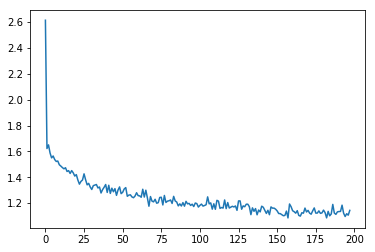

In [79]:
learning_rate = 0.001
hidden_size = 256

# encoder = PreBatchEncoderRNN(loaded_zh_embeddings, emb_size, hidden_size).to(device)
# attn_decoder = PreBatchAttnDecoderRNN(loaded_en_embeddings, emb_size,hidden_size, len(en_ordered_words)).to(device)

total_loss_list_en, plot_losses_en = AttnTrainIters(train_zh_loader, val_zh_loader, encoder, attn_decoder, 3,
               None, print_every=100, learning_rate=learning_rate)


In [80]:
import pickle as pkl
pkl.dump(total_loss_list_en, open('total_loss_list_en.p', 'wb'))
pkl.dump(plot_losses_en, open('plot_losses_en.p', 'wb'))

In [ ]:
total_loss_list_en3, plot_losses_en3 = AttnTrainIters(train_zh_loader, val_zh_loader, encoder, attn_decoder, 1,
               None, print_every=100, learning_rate=learning_rate)

1m 20s (- 87m 52s) (100 1%) 1.0752
2m 40s (- 85m 55s) (200 3%) 1.0620
4m 0s (- 84m 17s) (300 4%) 1.0473
5m 19s (- 82m 41s) (400 6%) 1.0268
6m 39s (- 81m 21s) (500 7%) 1.0890
7m 58s (- 79m 59s) (600 9%) 1.0692
9m 18s (- 78m 38s) (700 10%) 1.0784


In [107]:
len(plot_losses_en2)

132

In [108]:
plot_loss_append = plot_losses_en + plot_losses_en2

<Figure size 432x288 with 0 Axes>

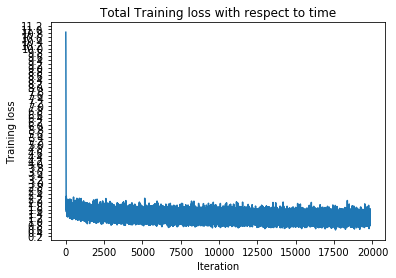

In [90]:
plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
ax.yaxis.set_major_locator(loc)
plt.plot(total_loss_list_en)

plt.title('Total Training loss with respect to time')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.savefig('total_zh_attn_training_loss.png')

<Figure size 432x288 with 0 Axes>

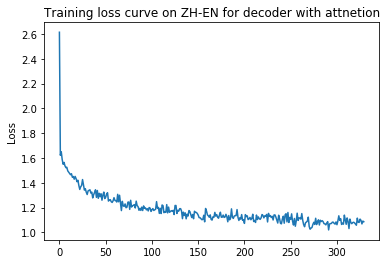

In [110]:
plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
ax.yaxis.set_major_locator(loc)
plt.plot(plot_loss_append)

plt.title('Training loss curve on ZH-EN for decoder with attnetion')
plt.ylabel('Loss')
plt.savefig('zh_attn_training_loss.png')

In [290]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [291]:
showPlot(plot_losses)

In [111]:
len(plot_loss_append)

330

In [112]:
pkl.dump(plot_loss_append, open('plot_losses_append_zh_attn.p', 'wb'))

In [92]:
decoder_backup = attn_decoder
encoder_backup = encoder

In [115]:
decoded_test, decoder_attentions = greedy_attn_evaluate(test_zh_loader, encoder, attn_decoder, en_id2words)
decoded_test_clean = post_process(decoded_test)

0/1396
100/1396
200/1396
300/1396
400/1396
500/1396
600/1396
700/1396
800/1396
900/1396
1000/1396
1100/1396
1200/1396
1300/1396


In [121]:
pkl.dump(decoded_test_clean, open('attn_decoded_test_clean5.p', 'wb'))

bleu score for test dataset: 13.244067757436477
bleu score for test dataset [raw]: 3.1149446308128703


In [169]:
random.choice(decoded_clean)

['so', 'there', 's', 'this', '.', 'this', '.', '.', '<EOS>']

In [ ]:
torch.cuda.get_device_name(0)

In [ ]:
time = timer()
i = 0
for batch in train_zh_loader:
    i += 1
print(i)

In [324]:
def beam_evaluate(val_loader, encoder, decoder, beam_width, k):
    '''
    beam_width: number of best nodes kept at each iterations
    k: number of sentences we want to keep
    Returns the translated batch
    '''
    
    
    decoded_batch = []
    #decoder_attentions = torch.zeros(max_length, batch_size, max_input_length)#in length, each position has attention

    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        
        for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
            if i %100 == 0:
                print("%d/%d"%(i,len(val_loader)))
                    
            #    break
            #batch_size, max_len = output_list.size()
#             print(input_list.size())
            
            encoder_hidden = encoder.initHidden(1)
            encoder_outputs, encoder_hidden = encoder(input_list, input_length, encoder_hidden)

            decoder_input = torch.tensor(np.array([[SOS_TOKEN]]), device=device) #SOS 1 sentence a time
            decoder_hidden = encoder_hidden[:decoder.n_layers] # decoder starts from the last encoding sentence
            # output of this function
            
            decoded_words = []
            #decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)
            
            start_node = SearchNode(decoder_input, decoder_hidden, prev = None, curr_score = 0, length = 1)
            nodes = PriorityQueue()
            nodes.put(( -(start_node.score), start_node))
            end_nodes = []
            

            while(len(end_nodes) < k):
                curr_score, curr_node = nodes.get()
                if (curr_node.word_idx == EOS_TOKEN) and (curr_node.prev != None):
                    end_nodes.append((-(curr_node.score),curr_node))
                    if len(end_nodes) >=k:
                        break;
                    else: 
                        continue;

                if nodes.qsize() >= MAX_LENGTH:#if too long will force to stop
                    #Create an EOS dummy node to trace back the entire sentence
                    EOS_node = SearchNode(torch.tensor([[EOS_TOKEN]], device = device), curr_node.hidden, 
                                          curr_node, curr_node.score, (curr_node.length)+1)
                    end_nodes.append((-(EOS_node.score), EOS_node))
                    if len(end_nodes) >= k:
                        break;
                    else:
                        continue;

                decoder_input = curr_node.word_idx
                decoder_hidden = curr_node.hidden

                # for each time step, the decoder network takes two inputs: previous outputs 
                #and the previous hidden states
                decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)


                scores, indexes = torch.topk(decoder_output, beam_width)
                candidate_nodes = []
                for i in range(beam_width):
                    candidate_idx = indexes[0][i].view(1, -1)
                    candidate_score = scores[0][i].item()

                    candidate_node = SearchNode(candidate_idx, decoder_hidden, 
                                                   curr_node, candidate_score, curr_node.length + 1)
                    candidate_nodes.append((-(candidate_node.score), candidate_node))

                for j in range(beam_width):
                    to_push_score, to_push_node = candidate_nodes[j]
                    #print(to_push_score)
                    nodes.put((-(to_push_score), to_push_node))
                #End of the while loop

            sentences = translate_end_nodes(end_nodes)
            decoded_batch.append(sentences)
            #End of the batch loop
        
    return decoded_batch

In [325]:
class SearchNode(object):
    def __init__(self, word_idx, hidden, prev, curr_score, length):
        self.hidden = hidden
        self.word_idx = word_idx
        self.prev = prev
        
        if self.prev == None:
            self.score = curr_score
        else:
            self.score = self.prev.score + curr_score
        self.length = length

#Translate the sentences.
def translate_end_nodes(end_nodes):
    sentences = []
    #end_nodes = sorted(end_nodes, key = operator.itemgetter(0),reverse = True)
    for _, end_node in end_nodes:
        sentence = []
        while end_node.prev != None:
            sentence.append(en_id2words[end_node.word_idx.item()])
            end_node = end_node.prev
        sentence = sentence[::-1]#Reverse the sentence to get the sentence
        sentences.append(sentence)
    return sentences


In [327]:
decoded_val = beam_evaluate(val_zh_loader, encoder, attn_decoder, 5,1)
decoded_clean = post_process(decoded_val)

0/1257
100/1257
200/1257
300/1257
400/1257
500/1257
600/1257
700/1257
800/1257
900/1257
1000/1257
1100/1257
1200/1257


In [105]:
train_zh_pairs[763]

['我们 欣慰 地 发现 国内 的 年轻 年轻人 正在 权威 地 解释 议事 阻挠 是 什么 为什么 什么 上院 议员 们 要 牺牲 睡眠 来 捍卫 原则',
 'and it was with great delight that we found young people up and down the country explaining with authority what filibustering was and why the lords might defy their bedtime on a point of principle .']